## Loading Dataset and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from random import *
import time

In [2]:
X_dataset = np.loadtxt('MNISTnumImages5000_balanced.txt', delimiter="\t", unpack=False)
Y_dataset = np.loadtxt('MNISTnumLabels5000_balanced.txt', unpack=False, dtype=int)

In [3]:
print(len(X_dataset))                           #check if data loaded successfully
print(len(Y_dataset))                           #check if labels loaded successfully

5000
5000


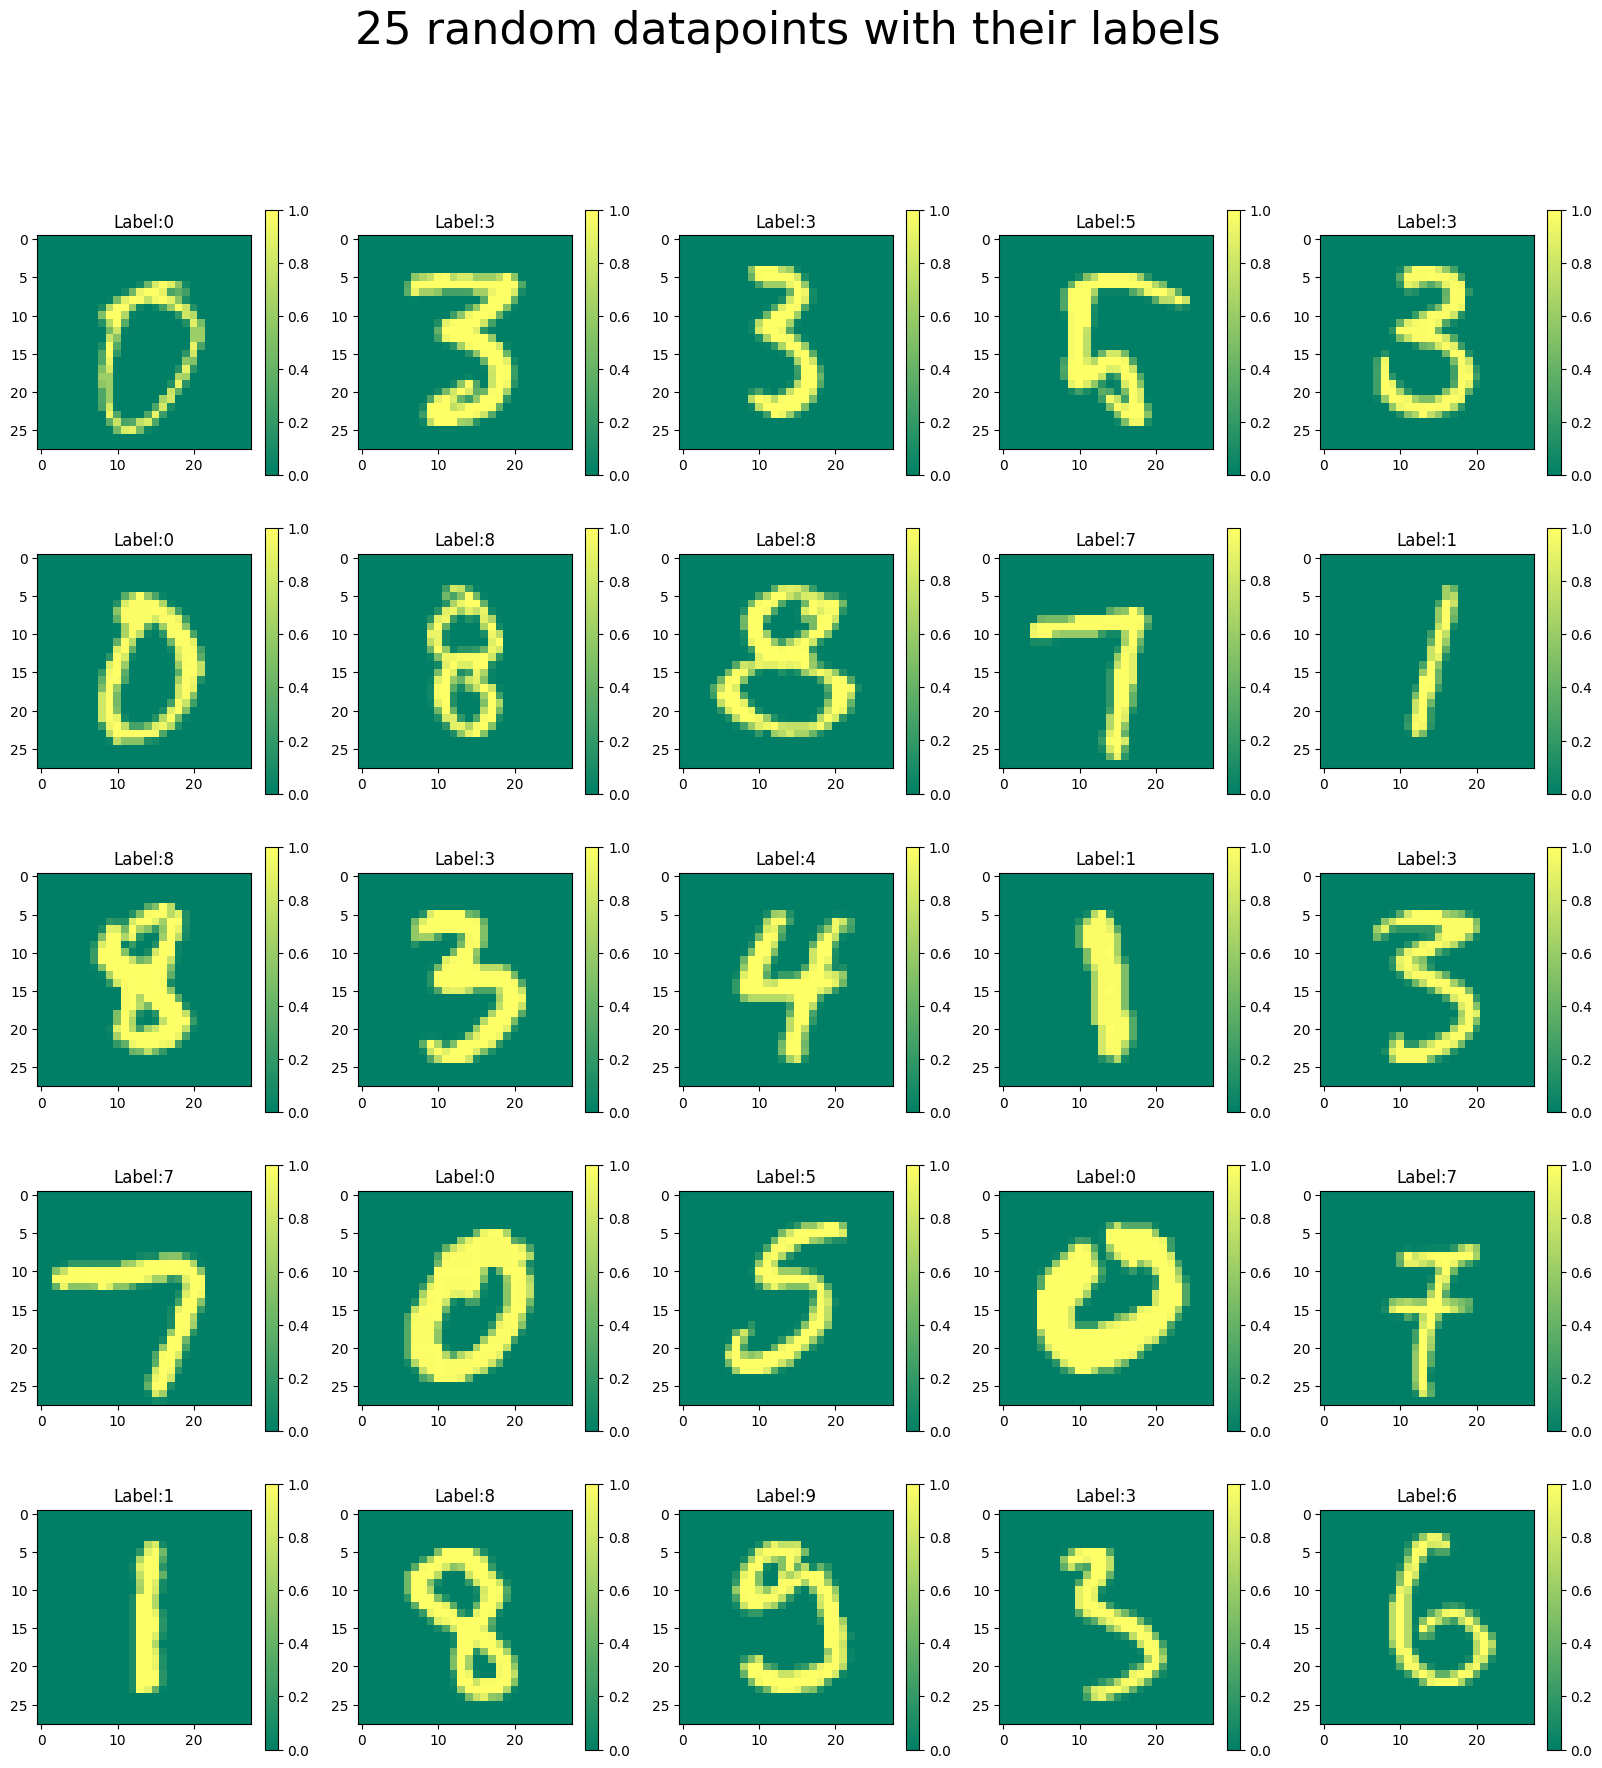

In [4]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
axs = axs.flatten()
plt.suptitle("25 random datapoints with their labels", fontsize=32)
for i in range(25):
    randval=randint(0,4999)
    p=axs[i].imshow(X_dataset[randval].reshape(28,28).T,cmap = 'summer')
    axs[i].set(title=f'Label:{Y_dataset[randval]}')
    plt.colorbar(p)


## Creating train and test dataset

In [5]:
X_train = np.concatenate((X_dataset[:400],                  #using first 400 datapoint from each class for X_train 
                          X_dataset[500:900],
                          X_dataset[1000:1400],
                          X_dataset[1500:1900],
                          X_dataset[2000:2400],
                          X_dataset[2500:2900],
                          X_dataset[3000:3400],
                          X_dataset[3500:3900],
                          X_dataset[4000:4400],
                          X_dataset[4500:4900]), axis = 0)

Y_train = np.concatenate((Y_dataset[:400],                  #using first 400 datapoint from each class for Y_train 
                          Y_dataset[500:900],
                          Y_dataset[1000:1400],
                          Y_dataset[1500:1900],
                          Y_dataset[2000:2400],
                          Y_dataset[2500:2900],
                          Y_dataset[3000:3400],
                          Y_dataset[3500:3900],
                          Y_dataset[4000:4400],
                          Y_dataset[4500:4900]), axis = 0)

X_test = np.concatenate((X_dataset[400:500],                #using last 100 datapoint from each class for X_test
                         X_dataset[900:1000],
                         X_dataset[1400:1500],
                         X_dataset[1900:2000],
                         X_dataset[2400:2500],
                         X_dataset[2900:3000],
                         X_dataset[3400:3500],
                         X_dataset[3900:4000],
                         X_dataset[4400:4500],
                         X_dataset[4900:5000]), axis = 0)

Y_test = np.concatenate((Y_dataset[400:500],                #using last 100 datapoint from each class for Y_test 
                         Y_dataset[900:1000],
                         Y_dataset[1400:1500],
                         Y_dataset[1900:2000],
                         Y_dataset[2400:2500],
                         Y_dataset[2900:3000],
                         Y_dataset[3400:3500],
                         Y_dataset[3900:4000],
                         Y_dataset[4400:4500],
                         Y_dataset[4900:5000]), axis = 0)

In [6]:
#checking if dataset sizes are correct

print('X_train size:',X_train.shape[0])
print('Y_train size:',Y_train.shape[0])
print('X_test size:',X_test.shape[0])
print('X_test size:',Y_test.shape[0])

X_train size: 4000
Y_train size: 4000
X_test size: 1000
X_test size: 1000


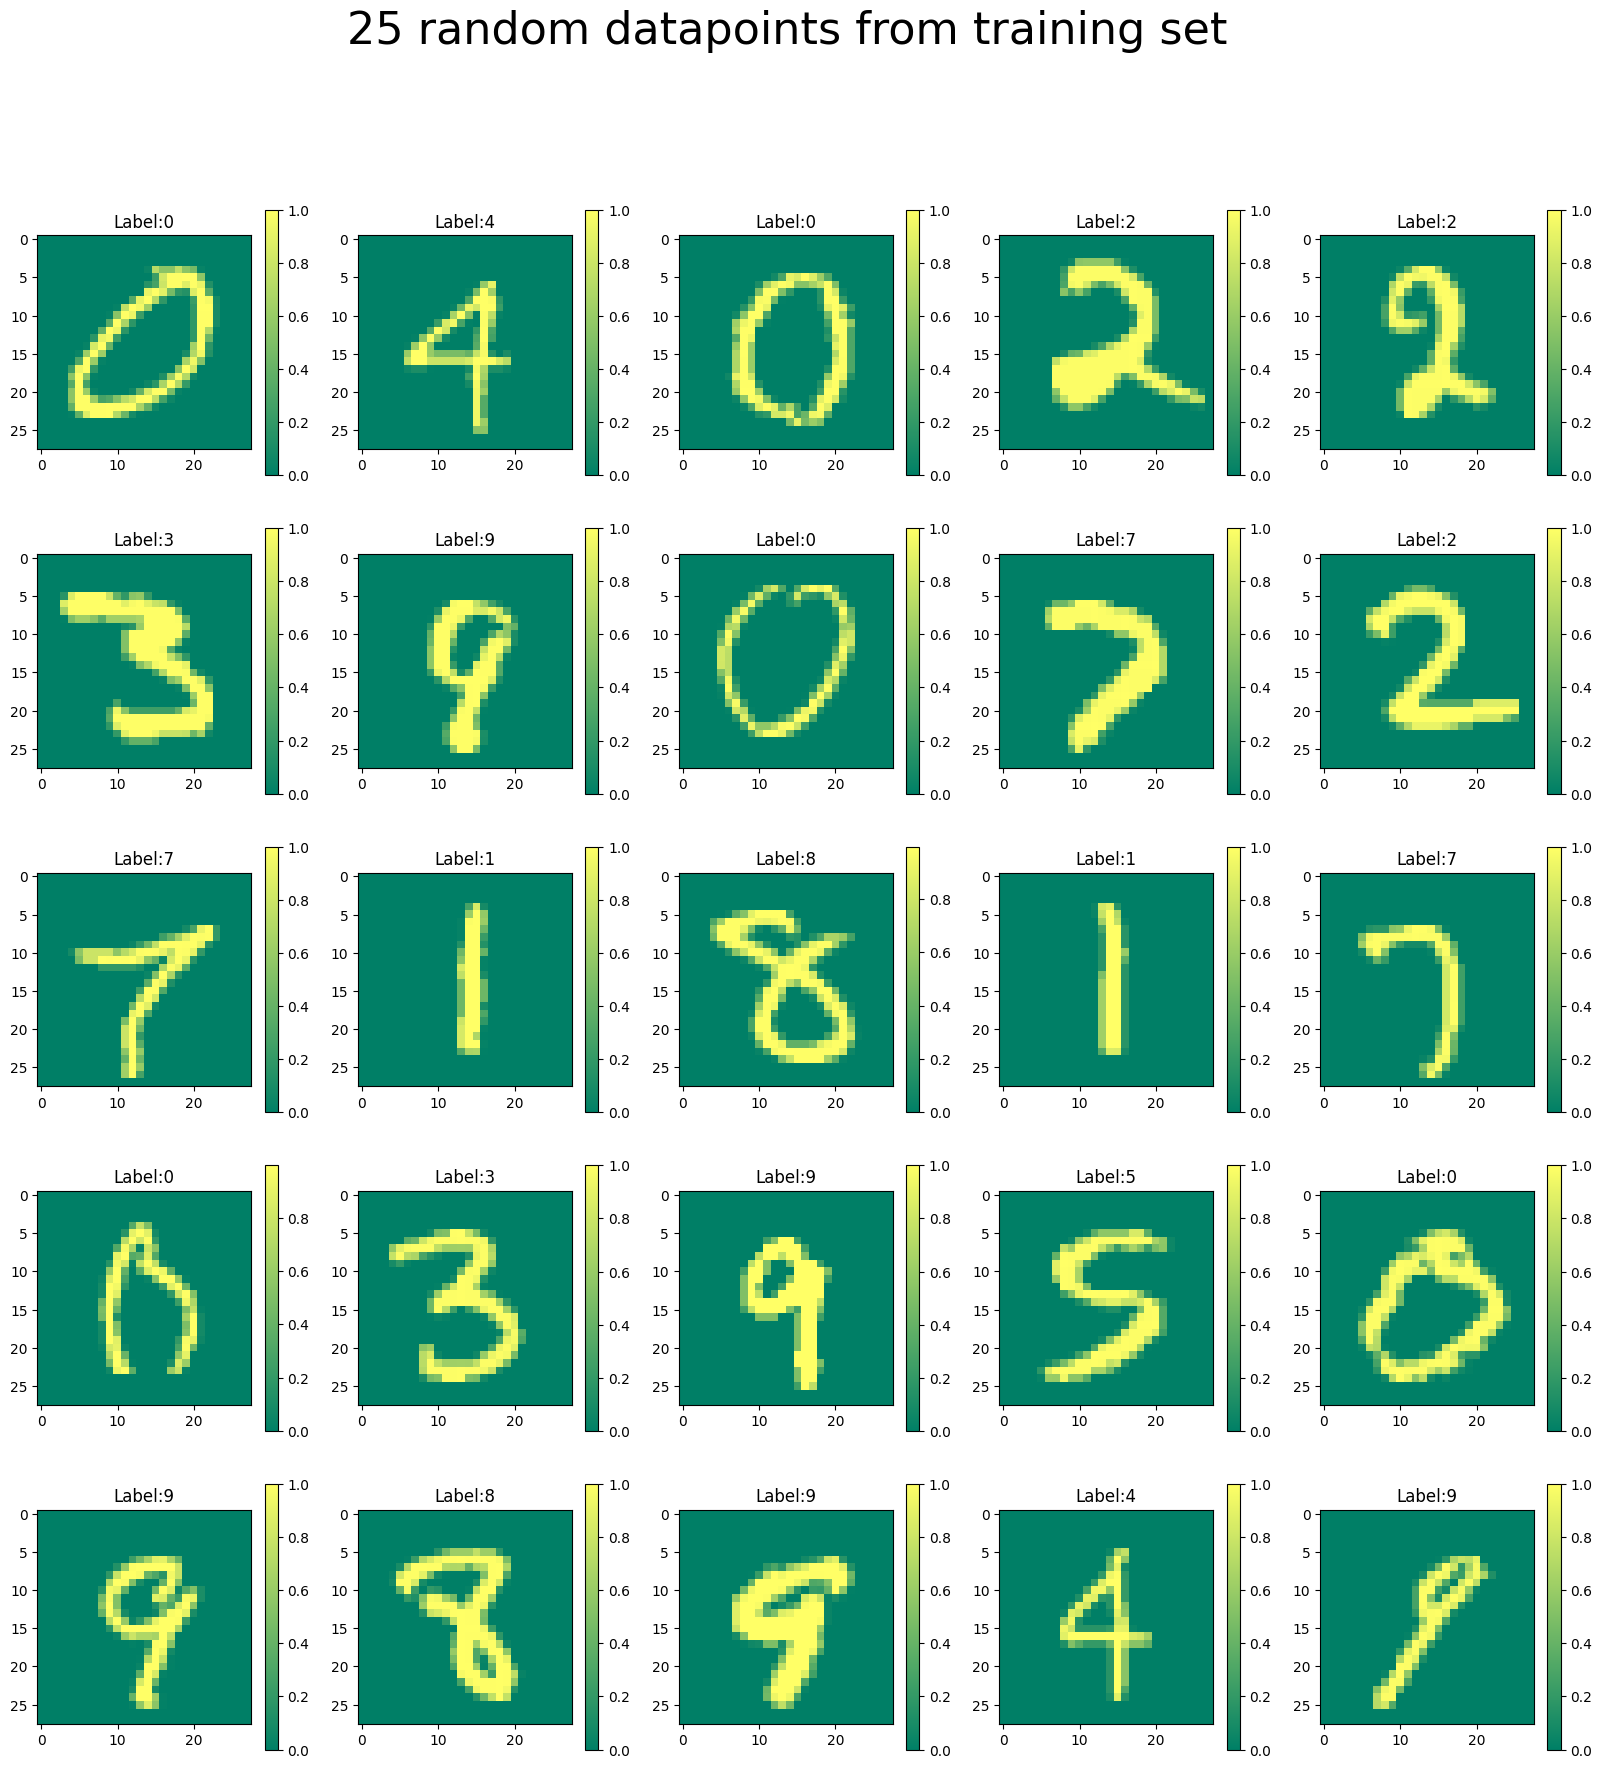

In [7]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
axs = axs.flatten()
plt.suptitle("25 random datapoints from training set", fontsize=32)
for i in range(25):
    randval=randint(0,3999)
    p=axs[i].imshow(X_train[randval].reshape(28,28).T,cmap = 'summer')
    axs[i].set(title=f'Label:{Y_train[randval]}')
    plt.colorbar(p)

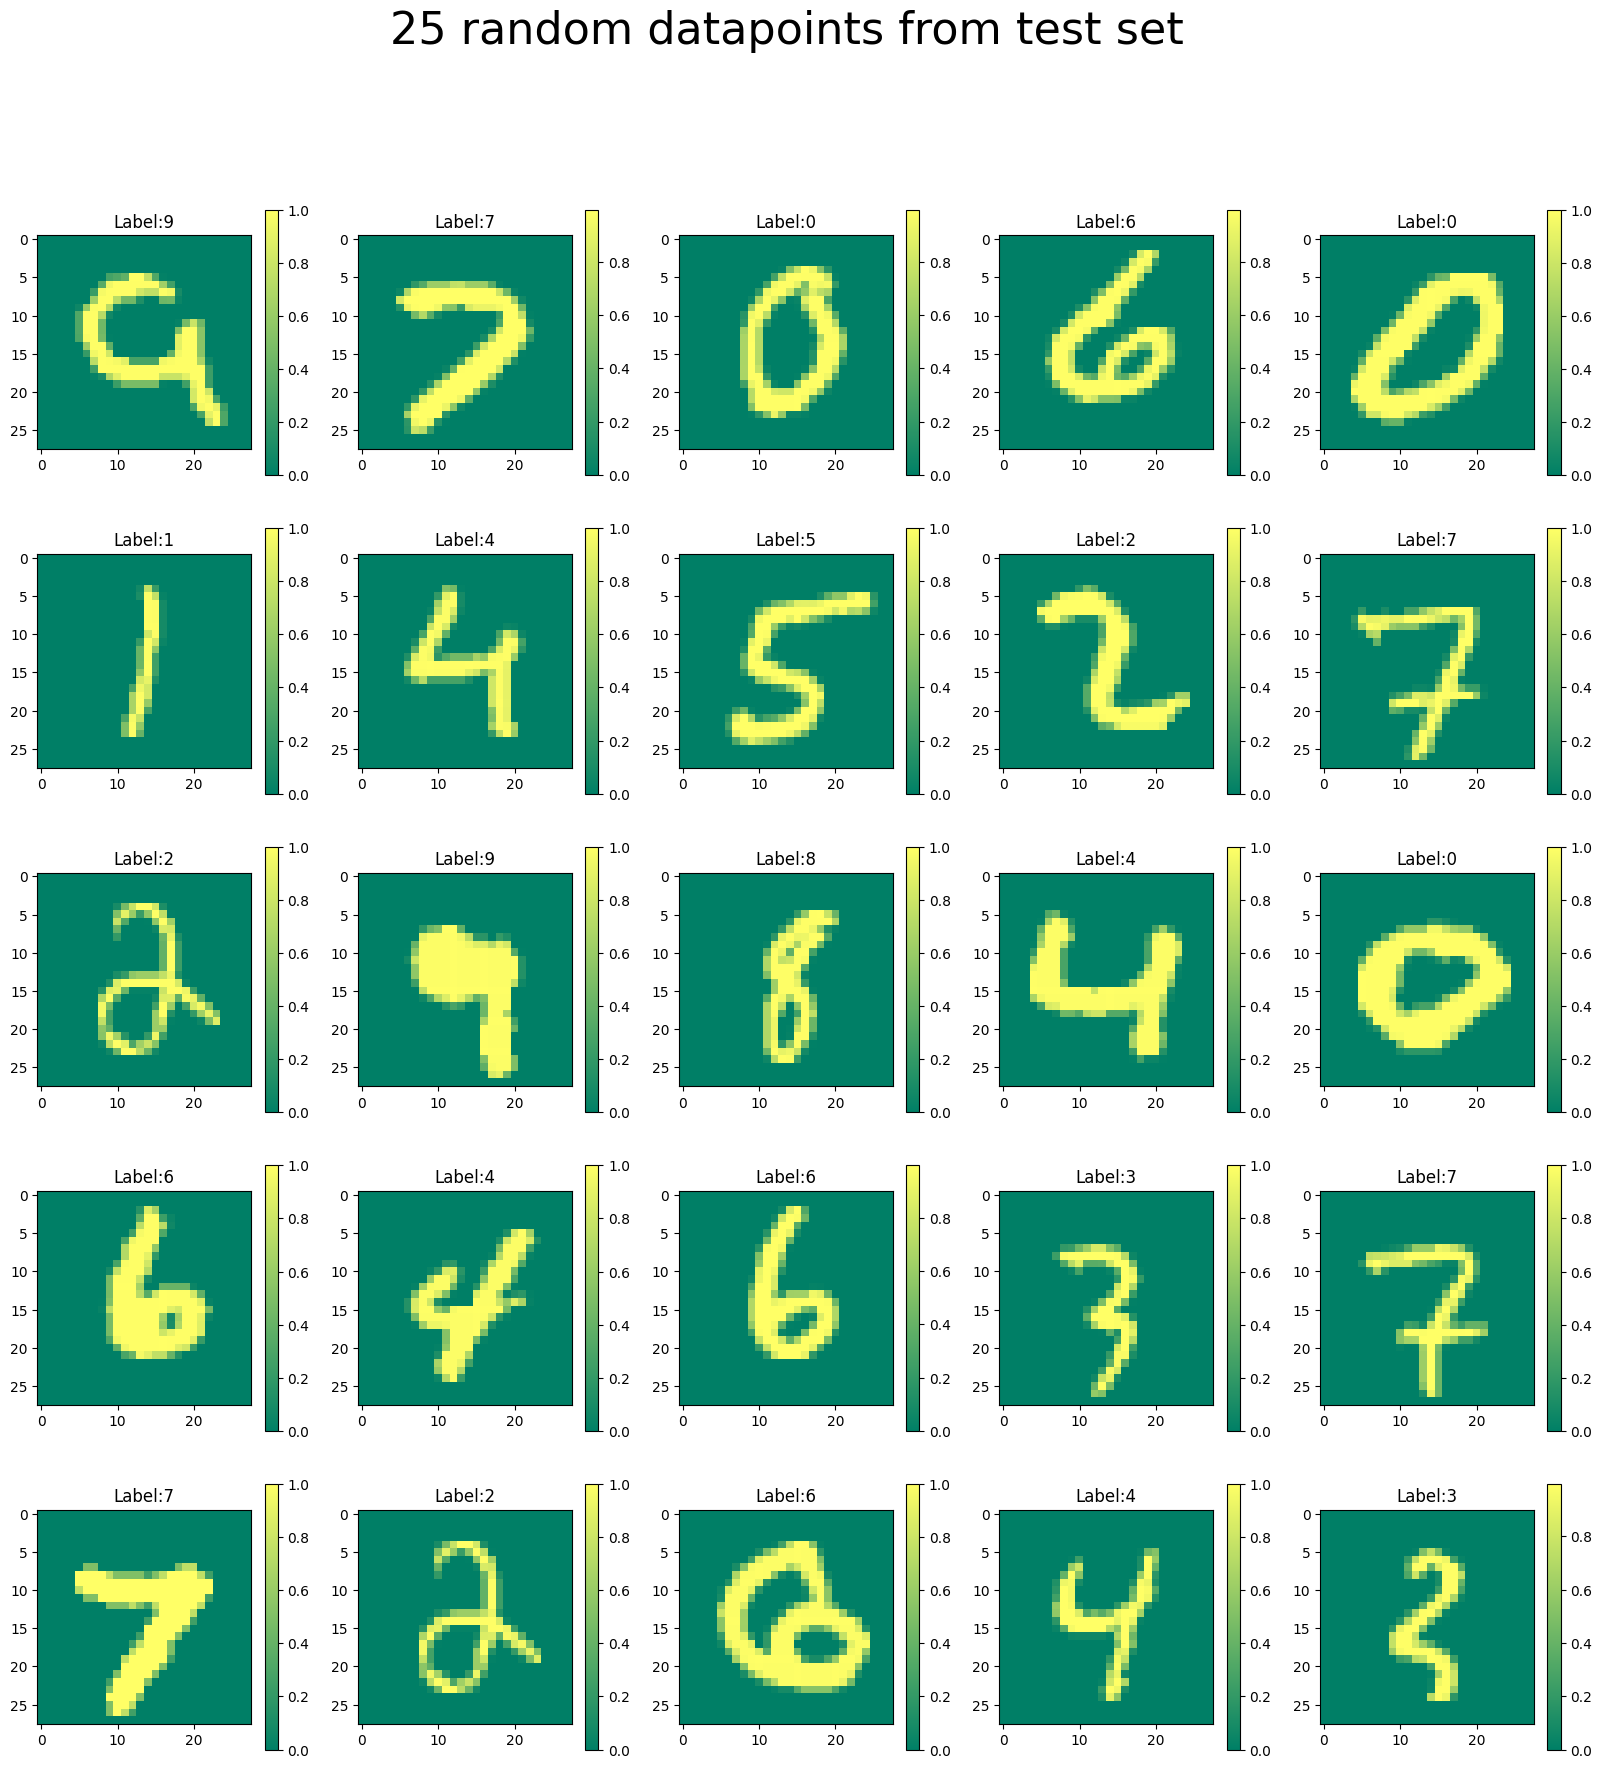

In [8]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
axs = axs.flatten()
plt.suptitle("25 random datapoints from test set", fontsize=32)
for i in range(25):
    randval=randint(0,999)
    p=axs[i].imshow(X_test[randval].reshape(28,28).T,cmap = 'summer')
    axs[i].set(title=f'Label:{Y_test[randval]}')
    plt.colorbar(p)

In [9]:
'''
Converting numpy arrays to torch tensors. Doesn't really make a difference,
I am just used to using tensors more than numpy for ML/DL
'''
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

Y_train = torch.tensor(Y_train)
Y_test = torch.tensor(Y_test)

In [10]:
#randomizing training data
torch.manual_seed(101)
shuffle_idx = torch.randperm(Y_train.size(0), dtype=torch.long)
X_train, Y_train = X_train[shuffle_idx], Y_train[shuffle_idx]

## <br><br> Defining model

In [11]:
#defining hyperparameters and constants

epochs = 200                         #number of epochs
n_classes = 10                       #number of output classes
l_rate = 0.01                        #learning rate
alpha = 0.9                          #alpha for momentum term


feature_size = X_train.shape[1]      #number of input features
neur_h1 = 160                        #number of neurons in first hidden layer

In [12]:
#not used

def weight_init(fr, to):             #function to define weight matrix between 2 layers
    weight = []
    for i in range(0, to):
        weight.append(0.5*np.random.rand(fr))
        
    weight = torch.tensor(weight)
    bias = torch.rand(to)*0.5
    return weight, bias

In [13]:
#not used

w1, b1 = weight_init(feature_size, neur_h1)        #initializing weights and biases for features to hidden layer 1
w2, b2 = weight_init(neur_h1, n_classes)           #initializing weights and biases hidden layer 1 to output layer

C:\Users\rabgu\AppData\Local\Temp\ipykernel_8240\3878047708.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  weight = torch.tensor(weight)


In [14]:
class NeuralNetwork():
    
    def __init__(self, feature_size, neur_h1, n_classes):
        super(NeuralNetwork, self).__init__()
        
        self.n_classes = n_classes
        
        
        #weights and biases
        #all weights are normally distributed from 0 to 0.1
        #all biases are zero
        self.w1 = torch.zeros(neur_h1, feature_size, dtype=torch.float64).normal_(0.0, 0.1)
        self.b1 = torch.zeros(neur_h1, dtype=torch.float64)
        self.w2 = torch.zeros(self.n_classes, neur_h1, dtype=torch.float64).normal_(0.0, 0.1)
        self.b2 = torch.zeros(self.n_classes, dtype=torch.float64)
        
        self.dl_by_dw2 = 0                                   #initializing all gradients to zero
        self.dl_by_dw1 = 0                                   #has to be doen for momentum
        self.dl_by_db2 = 0                                   #to avoid the delta update very first time
        self.dl_by_db1 = 0                                   #since delta at t(-1) does not exist otherwise
     
    def sigmoid(z):                                          #activation function definition
        for i in range(z.shape[0]):                          #iterating over rows and columns
            for j in range(z.shape[1]):
                z[i][j] = 1/ (1+torch.exp(-z[i][j]))         #each element gets sigmoid update
        return z           
        
        
    def forward(self, x):                                    #function for forward pass
        z1 = torch.mm(x, self.w1.t()) + self.b1              #forward pass on features outputs activations of layer 1
        a1 = torch.sigmoid(z1)                               #activation function    
        z2 = torch.mm(a1, self.w2.t()) + self.b2             #forward pass on hidden layer 1 outputs activs of class pred      
        a2 = torch.sigmoid(z2)                               #activation function
        return a1, a2            

            
    def backward(self, x, y, a1, a2):
        #creaing one hot encoded matrix of Y actual labels
        y_hot = torch.FloatTensor(y.size(0), self.n_classes) #defining matrix of batch size by output classes
        y_hot.zero_()                                        #converting all the elements to zeros
        y_hot.scatter_(1, y.view(-1,1).long(), 1)            #making a one hot matrix


        #computing derivative of loss from output to hidden layer using chain rule
        dl_by_da2  = 2.*(a2 - y_hot) / y.size(0)             #derivative of loss w.r.t activation2
        da2_by_dz2 = a2*(1. - a2)                            #derivative of activation2 w.r.t net inputs2
        dz2_by_dw2 = a1                                      #derivative of net inputs2 w.r.t. weights2
        dl_by_dz2  = dl_by_da2 * da2_by_dz2                  #temporary: multiplication of above two values

        
        #delta weight and bias for output layer with momentum
        self.dl_by_dw2 = alpha*self.dl_by_dw2 - l_rate*torch.mm(dl_by_dz2.t(), dz2_by_dw2)    
        self.dl_by_db2 = alpha*self.dl_by_db2 - l_rate*torch.sum(dl_by_dz2, dim = 0)


        #computing derivative of loss from hidden layer to input features using chain rule
        dz2_by_da1 = self.w2                                            #derivative of net input2 wrt activation1
        da1_by_dz1 = a1*(1. - a1)                                       #derivative of activation1 wrt net input1
        dz1_by_dw1 = x                                                  #derivative of net input1 wrt weights1
        dl_by_da1  = torch.mm(dl_by_dz2, dz2_by_da1)                    #temp: mat mul of prev temp and dz2byda1
        
        
        #delta weight and bias for hidden layer with momentum
        self.dl_by_dw1 = alpha*self.dl_by_dw1 - l_rate*torch.mm((dl_by_da1*da1_by_dz1).t(), dz1_by_dw1)    
        self.dl_by_db1 = alpha*self.dl_by_db1- l_rate*torch.sum((dl_by_da1*da1_by_dz1), dim = 0)           

        return self.dl_by_dw2, self.dl_by_db2, self.dl_by_dw1, self.dl_by_db1

In [15]:
def one_hot(y, n_classes):
    y_hot = torch.FloatTensor(y.size(0), n_classes)    #defining matrix of batch size by output classes
    y_hot.zero_()                                      #converting all the elements to zeros
    y_hot.scatter_(1, y.view(-1,1).long(),1)           #making a one hot matrix
    return y_hot

In [16]:
def loss(y_hot, a2):                                             #defining MSE loss function
    return torch.mean(torch.mean((y_hot - a2)**2, dim = 0))      #returning sum sq diff of predicted and actual labels

In [17]:
def training(model, x, y, x_test, y_test, epochs, l_rate):
    mini_b_size = 100                                            #taking a minibatch size of 100
    m_batches = y.size(0)//mini_b_size                           #total minibatches = dataset size / minibatchsize
    err_f_epoch = []
    err_f_epoch_test = []
    a1, a2 = model.forward(x)                                    #error without training
    err_f = torch.argmax(a2, dim = 1) - y                        #difference of predictions
    err_f = torch.sum(err_f) / err_f.size(0)                     #computing error fraction
    err_f = err_f !=0                                            #converting to True/False
    err_f = err_f.long()                                         #converting to 0 and 1
    err_f_epoch.append(err_f)                                    #error fraction of the whole epoch
    
    a1_test, a2_test = model.forward(x_test)                     #forward pass on test data
    err_f_test = torch.argmax(a2_test, dim = 1) - y_test         #difference of predictions
    err_f_test = err_f_test !=0                                  #converting to True/False
    err_f_test = err_f_test.long()                               #converting to 0 and 1
    err_f_test = torch.sum(err_f_test) / err_f_test.size(0)      #computing error fraction
    err_f_epoch_test.append(err_f_test)                          #test error without training
        
    for e in range(epochs):                                      #iterating over epochs
        st, end= 0,mini_b_size                                   #index for minibatch size
        err_sum = 0
        
        for _ in range(m_batches):                               #iterating over minibatches
            
            #data for minibatch
            x_b = x[st:end]                                      
            y_b = y[st:end]
            
            #predictions
            a1, a2 = model.forward(x_b)

            #backpropagation
            dl_by_dw2, dl_by_db2, dl_by_dw1, dl_by_db1 = model.backward(x_b, y_b, a1, a2)

            #parameters updation
            model.w2 += dl_by_dw2
            model.w1 += dl_by_dw1
            model.b2 += dl_by_db2
            model.b1 += dl_by_db1

            #error/loss function
            y_hot = one_hot(y_b, model.n_classes)
            error = loss(y_hot, a2)
            
            #forward pass on testing
            a1_test, a2_test = model.forward(x_test)
            
            #updating minibatch index
            st+=mini_b_size
            end+=mini_b_size
            
            #error fraction for training
            err_f = torch.argmax(a2, dim = 1) - y_b                 #difference of predictions
            err_f = err_f !=0                                       #converting to True/False
            err_f = err_f.long()                                    #converting to 0 and 1
            err_f = torch.sum(err_f) / err_f.size(0)                #computing error fraction
            err_sum += err_f                                        #summing them up over complete minibatch
        


        if (e+1)%10 == 0:                                           #for every 10th epoch
            err_f_epoch.append(err_sum/m_batches)                   #error fraction of the whole epoch
        
            #error fraction for testing
            a1_test, a2_test = model.forward(x_test)                #forward pass on test data
            
            err_f_test = torch.argmax(a2_test, dim = 1) - y_test    #difference of predictions
            err_f_test = err_f_test !=0                             #converting to True/False
            err_f_test = err_f_test.long()                          #converting to 0 and 1
            err_f_test = torch.sum(err_f_test) / err_f_test.size(0) #computing error fraction
            err_f_epoch_test.append(err_f_test)
        
        
        #displaying progress of epoch
        print('Epoch: %04d/%04d || Loss:%.3f' %(e+1,epochs,error))

        
    return a1, a2, err_f_epoch, err_f_epoch_test

In [18]:
torch.manual_seed(101)                                                            #setting manual seed for repeatable results
model = NeuralNetwork(feature_size, neur_h1, n_classes)                           #initializing model
init_w1, init_w2, init_b1, init_b2 = model.w1, model.w2, model.b1, model.b2       #saving initial weights and biases

## Training the model

In [19]:
a1, a2, err_train, err_test = training(model, X_train, Y_train, X_test, Y_test, epochs, l_rate)  #calling train function
err_train = np.asarray(err_train)                                                                #converting list to np array
err_test = np.asarray(err_test)                                                                  #converting list to np array

Epoch: 0001/0200 || Loss:0.095
Epoch: 0002/0200 || Loss:0.092
Epoch: 0003/0200 || Loss:0.089
Epoch: 0004/0200 || Loss:0.084
Epoch: 0005/0200 || Loss:0.079
Epoch: 0006/0200 || Loss:0.075
Epoch: 0007/0200 || Loss:0.070
Epoch: 0008/0200 || Loss:0.065
Epoch: 0009/0200 || Loss:0.061
Epoch: 0010/0200 || Loss:0.057
Epoch: 0011/0200 || Loss:0.054
Epoch: 0012/0200 || Loss:0.051
Epoch: 0013/0200 || Loss:0.049
Epoch: 0014/0200 || Loss:0.046
Epoch: 0015/0200 || Loss:0.045
Epoch: 0016/0200 || Loss:0.043
Epoch: 0017/0200 || Loss:0.041
Epoch: 0018/0200 || Loss:0.040
Epoch: 0019/0200 || Loss:0.039
Epoch: 0020/0200 || Loss:0.037
Epoch: 0021/0200 || Loss:0.036
Epoch: 0022/0200 || Loss:0.035
Epoch: 0023/0200 || Loss:0.035
Epoch: 0024/0200 || Loss:0.034
Epoch: 0025/0200 || Loss:0.033
Epoch: 0026/0200 || Loss:0.032
Epoch: 0027/0200 || Loss:0.032
Epoch: 0028/0200 || Loss:0.031
Epoch: 0029/0200 || Loss:0.031
Epoch: 0030/0200 || Loss:0.030
Epoch: 0031/0200 || Loss:0.030
Epoch: 0032/0200 || Loss:0.029
Epoch: 0

## Plotting

Text(0.5, 1.0, 'Fig 1(c)\nTrain and Test error fractions as a function of epochs run')

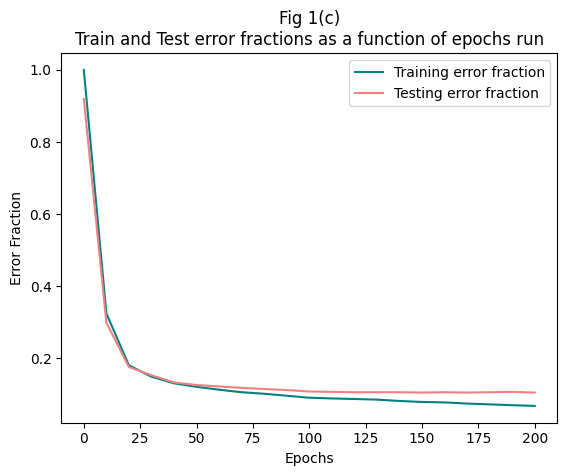

In [28]:
x_plot = np.arange(0, epochs+10, 10)
plt.plot(x_plot, err_train, color = 'teal', label = 'Training error fraction')
plt.plot(x_plot, err_test, color = 'lightcoral', label = 'Testing error fraction')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error Fraction')
plt.title('Fig 1(c)\nTrain and Test error fractions as a function of epochs run')

In [21]:
temp_a1, temp_a2 = model.forward(X_train)             #running a forward pass after training
y_pred_train = torch.argmax(temp_a2, dim = 1)         #getting predicted outputs based on max value of it
cm_train = np.asarray([[0]*10]*10)                    #defining a 10x10 matrix of zeros
for i in range(len(y_pred_train)):                    #running a loop of size of predictions
    cm_train[Y_train[i]][y_pred_train[i]]+=1          #updating the array
print(cm_train)

[[394   0   0   0   0   1   3   0   2   0]
 [  0 390   2   1   1   0   2   0   4   0]
 [  2   0 366   4   4   2   5   8   6   3]
 [  0   0   6 366   1   8   1   6   4   8]
 [  0   1   0   0 380   0   3   1   2  13]
 [  7   3   0   8   7 356   4   2   9   4]
 [  5   3   0   1   2   5 381   2   1   0]
 [  3   5   9   0   7   1   1 365   3   6]
 [  3   2   2   6   5   6   1   2 371   2]
 [  3   3   0   7  13   3   2   2   7 360]]


In [22]:
temp_a1, temp_a2 = model.forward(X_test)              #running a forward pass after training
y_pred_test = torch.argmax(temp_a2, dim = 1)          #getting predicted outputs based on max value of it
cm_test = np.asarray([[0]*10]*10)                     #defining a 10x10 matrix of zeros
for i in range(len(y_pred_test)):                     #running a loop of size of predictions
    cm_test[Y_test[i]][y_pred_test[i]]+=1             #updating the array
print(cm_test)

[[98  0  0  1  0  0  0  0  1  0]
 [ 0 95  0  3  0  1  0  1  0  0]
 [ 0  0 82  3  3  1  1  5  5  0]
 [ 0  0  3 88  2  2  0  2  3  0]
 [ 0  0  0  0 90  0  3  0  0  7]
 [ 0  0  1  1  0 88  5  1  4  0]
 [ 0  0  1  0  0  4 94  0  1  0]
 [ 0  2  2  2  1  0  1 89  0  3]
 [ 1  1  0  4  2  1  2  1 85  3]
 [ 1  2  0  1  8  1  0  1  0 86]]


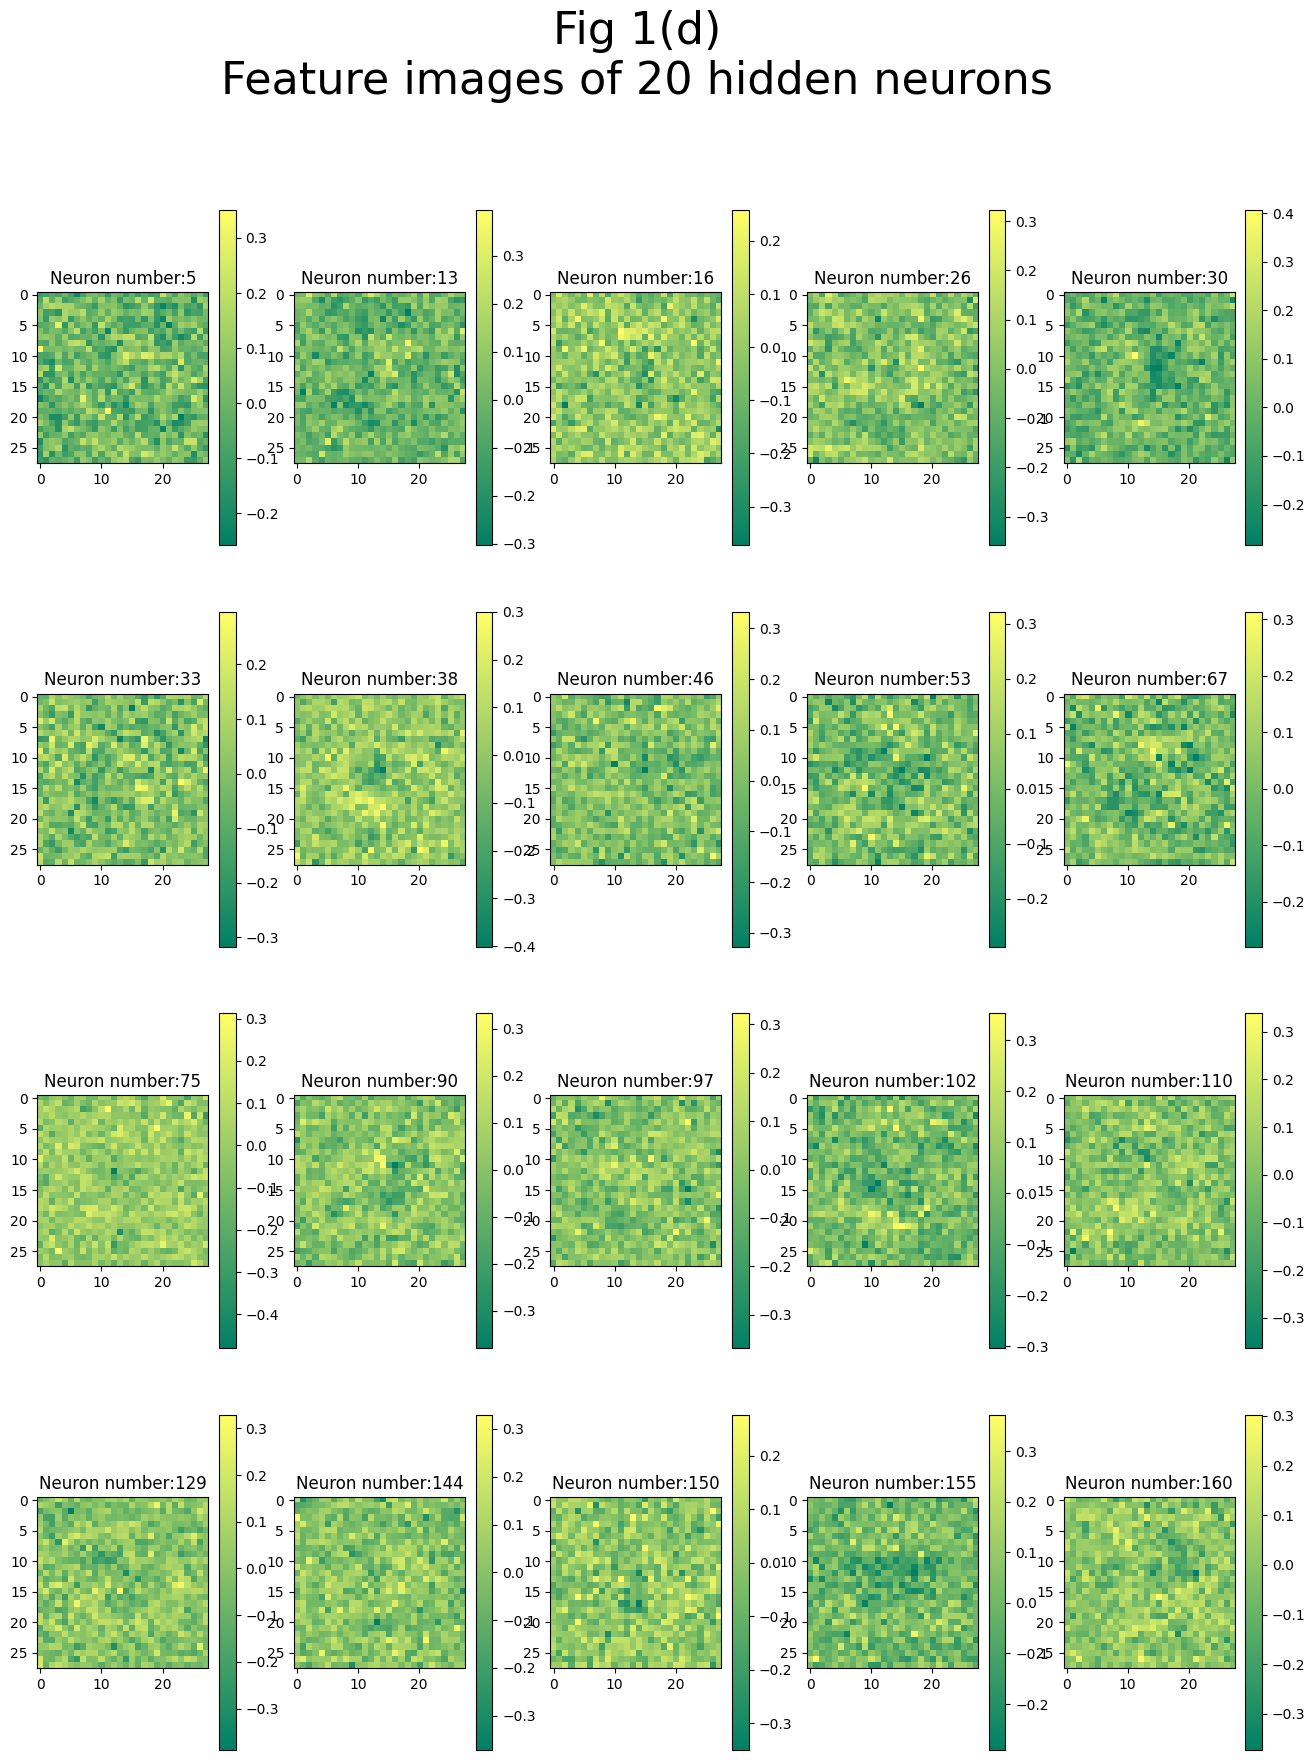

In [23]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(16, 20))
axs = axs.flatten()
arr = [4, 12, 15, 25, 29, 32, 37, 45, 52, 66, 74, 89, 96, 101, 109, 128, 143, 149, 154, 159]
plt.suptitle("Fig 1(d)\nFeature images of 20 hidden neurons", fontsize=32)
for i in range(len(arr)):
    p=axs[i].imshow(init_w1[arr[i]].reshape(28,28).T,cmap = 'summer')
    axs[i].set(title=f'Neuron number:{arr[i]+1}')
    plt.colorbar(p)